In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from notears.linear import notears_linear
import networkx as nx
import matplotlib.pyplot as plt

# 데이터 전처리
df = pd.read_csv("training_data.csv")
# X = df.values
# label 제거 필요
X = df.drop(columns=["Unnamed: 0", "label"]).values
X = StandardScaler().fit_transform(X)

# NOTEARS 실행
W = notears_linear(X, lambda1=0.1, loss_type='l2')  # lambda1으로 sparsity 조절

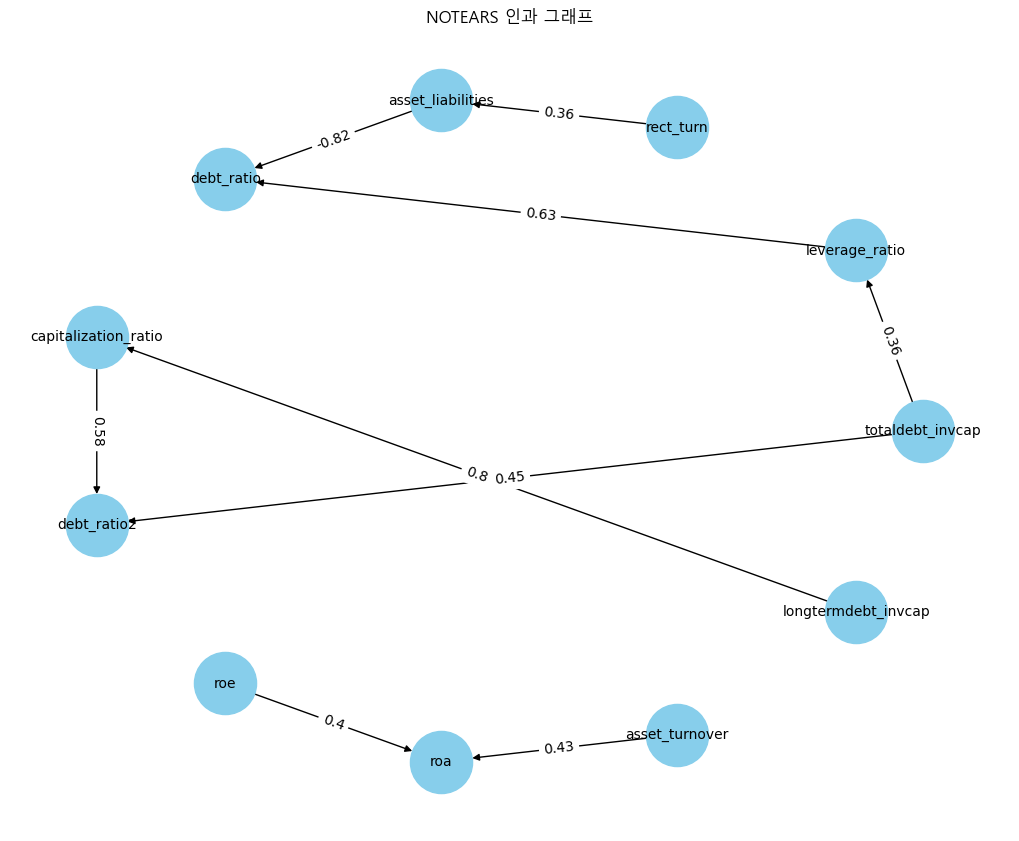

In [2]:
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


# 인과 그래프 시각화
cols = df.columns[1:-1]  # label 제외한 열 이름
G = nx.DiGraph()

for i in range(len(cols)):
    for j in range(len(cols)):
        if abs(W[i, j]) > 0.01:  # threshold 적용(0 제외)
            G.add_edge(cols[j], cols[i], weight=round(W[i, j], 2))

plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.kamada_kawai_layout(G)
pos = nx.circular_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.title("NOTEARS 인과 그래프")
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_19600\3869419372.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


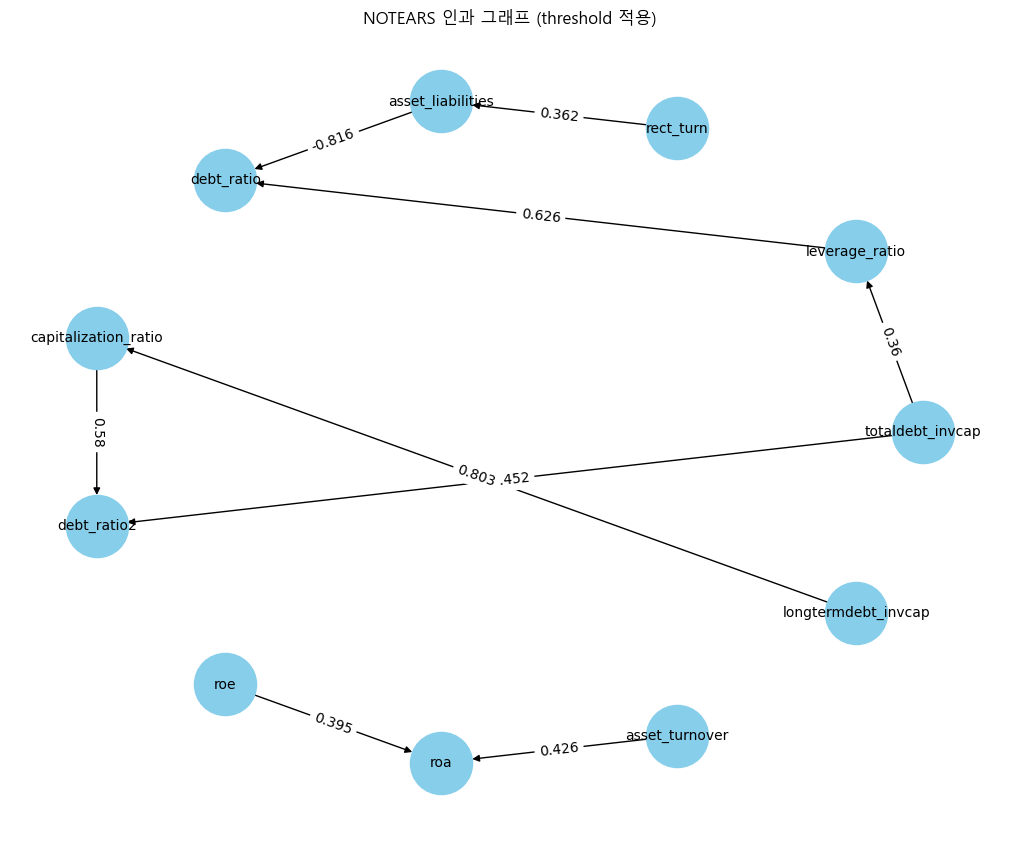

[DONE] mode=original__setting=original  ->  F1=0.4734  ACC=0.9751  P=0.4444  R=0.5063


NameError: name 'datetime' is not defined

In [4]:
# -----------------------------------------
# 3) 인과 기반 파생피처 생성
# -----------------------------------------
def generate_added_features(X_base: pd.DataFrame, cols, W: np.ndarray, mode: str,
                            w_threshold: float = 0.01, use_quantile: bool = False, q: float = 0.90) -> pd.DataFrame:
    """
    mode 토큰:
      - 'original' : 추가 피처 없음
      - 'mul'      : A*B
      - 'sub'      : A-B
      - 'mul*w'    : w_ij * (A*B)
      - 'sub*w'    : w_ij * (A-B)
    여러 개 조합 시 '+'로 연결 (예: 'mul+sub', 'mul+sub+mul*w')
    """
    new_features = pd.DataFrame(index=X_base.index)

    tokens = set(mode.split("+")) if mode else set()
    if tokens == {"original"} or mode == "original":
        return new_features

    thr = get_w_threshold(W, fixed_thr=w_threshold, use_quantile=use_quantile, q=q)

    n = len(cols)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w_ij = float(W[i, j])
            if abs(w_ij) <= thr:
                continue

            A = cols[j]  # 원인(부모)
            B = cols[i]  # 결과(자식)

            # 비가중
            if "mul" in tokens:
                new_features[f"{A}_mul_{B}"] = X_base[A] * X_base[B]
            if "sub" in tokens:
                new_features[f"{A}_sub_{B}"] = X_base[A] - X_base[B]

            # 가중
            if "mul*w" in tokens:
                new_features[f"{A}_mulw_{B}"] = w_ij * (X_base[A] * X_base[B])
            if "sub*w" in tokens:
                new_features[f"{A}_subw_{B}"] = w_ij * (X_base[A] - X_base[B])

    return new_features

# -----------------------------------------
# 4) 데이터셋 구성
# -----------------------------------------
def build_dataset_by_setting(mode: str, setting: str, X_base: pd.DataFrame, cols, W: np.ndarray,
                             w_threshold: float = 0.01, use_quantile: bool = False, q: float = 0.90) -> pd.DataFrame:
    """
    setting:
      - 'original'               : 원본 X_base
      - 'feature_only'           : 인과 피처만
      - 'original_plus_feature'  : 원본 + 인과 피처
    """
    if setting == "original":
        return X_base.copy()

    X_added = generate_added_features(X_base, cols, W, mode,
                                      w_threshold=w_threshold, use_quantile=use_quantile, q=q)

    if setting == "feature_only":
        return X_added

    if setting == "original_plus_feature":
        return pd.concat([X_base, X_added], axis=1)

    raise ValueError(f"Unknown setting: {setting}")

# -----------------------------------------
# 5) 학습/평가/저장 (MLP)
# -----------------------------------------
def train_and_save(X: pd.DataFrame, y: pd.Series, out_dir: Path,
                   random_state: int = RANDOM_STATE, test_size: float = TEST_SIZE,
                   param_grid: dict = PARAM_GRID) -> dict:
    out_dir.mkdir(parents=True, exist_ok=True)

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    (tr_idx, te_idx), = splitter.split(X, y)
    X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
    y_train, y_test = y.iloc[tr_idx], y.iloc[te_idx]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            random_state=random_state,
            max_iter=500,
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.15
        ))
    ])

    grid = GridSearchCV(pipe, param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_

    y_pred = best_pipe.predict(X_test)
    metrics = {
        "f1": float(f1_score(y_test, y_pred)),
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred, zero_division=0)),
        "recall": float(recall_score(y_test, y_pred))
    }

    dump(best_pipe, out_dir / "model.joblib")
    # 주의: parquet 저장엔 pyarrow/fastparquet 필요
    X_test.to_parquet(out_dir / "X_test.parquet")
    y_test.to_frame("label").to_parquet(out_dir / "y_test.parquet")

    with open(out_dir / "metrics.json", "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

    with open(out_dir / "report.txt", "w", encoding="utf-8") as f:
        f.write(classification_report(y_test, y_pred, digits=4))

    return metrics

# -----------------------------------------
# (NEW) 레지스트리 CSV 저장 유틸 — 파일명: registry_MLP.csv
# -----------------------------------------
def save_registry_csv(entries: list[dict], registry_path: Path):
    """
    entries: 실험 결과 dict들의 리스트
    registry_path: 저장할 CSV 전체 경로 (예: runs/mlp_notears/registry_MLP.csv)
    """
    df_new = pd.DataFrame(entries)

    # 디렉터리 보장
    registry_path.parent.mkdir(parents=True, exist_ok=True)

    if registry_path.exists():
        df_old = pd.read_csv(registry_path)
        df_all = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_all = df_new

    # 컬럼 정렬(가독성을 위해 주요 메타/스코어 먼저)
    preferred_cols = [
        "timestamp", "run_dir", "mode", "setting",
        "n_base_features", "n_added_features", "n_features",
        "w_threshold", "use_quantile", "q", "plot_layout",
        "random_state", "test_size",
        "f1", "accuracy", "precision", "recall"
    ]
    ordered = [c for c in preferred_cols if c in df_all.columns] + \
              [c for c in df_all.columns if c not in preferred_cols]
    df_all = df_all[ordered]

    df_all.to_csv(registry_path, index=False)

# -----------------------------------------
# 6) 전체 실험 루프
# -----------------------------------------
def run_experiments(df: pd.DataFrame, W: np.ndarray,
                    out_base: Path = Path("runs/mlp_notears"),
                    w_threshold: float = 0.01, use_quantile: bool = False, q: float = 0.90,
                    plot_layout: str = "circular"):
    """
    df: 원본 DataFrame (label 포함)
    W : NOTEARS 가중치 행렬
    """
    # 학습에 사용할 원본 피처/라벨
    to_drop = [c for c in ["Unnamed: 0", "label"] if c in df.columns]
    feature_cols = df.drop(columns=to_drop).columns
    cols = list(feature_cols)
    X_base = df[feature_cols].copy()
    y = df["label"].astype(int)

    # 6-1) 인과 그래프 확인(옵션)
    plot_causal_graph(W, cols, layout=plot_layout,
                      w_threshold=w_threshold, use_quantile=use_quantile, q=q,
                      title="NOTEARS 인과 그래프 (threshold 적용)")

    # 6-2) 실험 설정
    modes = [
        "original",                 # 추가 피처 없음(베이스라인)
        "mul",
        "sub",
        "mul+sub",
        "mul*w",
        "sub*w",
        "mul+sub+mul*w+sub*w"
    ]
    settings = ["original", "original_plus_feature", "feature_only"]

    results = []
    registry_entries = []  # CSV 레지스트리용

    for mode in modes:
        for setting in settings:
            # feature_only인데 mode가 original이면 무의미(빈 DF) → 스킵
            if mode == "original" and setting == "feature_only":
                continue

            X_built = build_dataset_by_setting(
                mode=mode, setting=setting,
                X_base=X_base, cols=cols, W=W,
                w_threshold=w_threshold, use_quantile=use_quantile, q=q
            )

            # feature_only인데 생성된 피처가 하나도 없으면 스킵
            if setting == "feature_only" and X_built.shape[1] == 0:
                continue

            tag = f"mode={mode}__setting={setting}"
            out_dir = out_base / tag

            metrics = train_and_save(X_built, y, out_dir=out_dir)
            print(f"[DONE] {tag}  ->  F1={metrics['f1']:.4f}  ACC={metrics['accuracy']:.4f}  "
                  f"P={metrics['precision']:.4f}  R={metrics['recall']:.4f}")

            results.append({
                "mode": mode,
                "setting": setting,
                **metrics
            })

            # 레지스트리 행 생성
            base_cols_set = set(X_base.columns)
            added_cols = [c for c in X_built.columns if c not in base_cols_set]
            n_added = len(added_cols) if setting != "original" else 0

            registry_entries.append({
                "timestamp": datetime.now().isoformat(timespec="seconds"),
                "run_dir": str(out_dir.resolve()),
                "mode": mode,
                "setting": setting,
                "n_base_features": int(X_base.shape[1]),
                "n_added_features": int(n_added),
                "n_features": int(X_built.shape[1]),
                "w_threshold": float(w_threshold),
                "use_quantile": bool(use_quantile),
                "q": float(q),
                "plot_layout": plot_layout,
                "random_state": int(RANDOM_STATE),
                "test_size": float(TEST_SIZE),
                "f1": float(metrics["f1"]),
                "accuracy": float(metrics["accuracy"]),
                "precision": float(metrics["precision"]),
                "recall": float(metrics["recall"]),
            })

    # 결과 요약 저장(JSON)
    summary_path = out_base / "summary_results.json"
    out_base.mkdir(parents=True, exist_ok=True)
    with open(summary_path, "w", encoding="utf-8") as f:
        json.dump(results, f, ensure_ascii=False, indent=2)

    # 레지스트리 CSV 저장 (누적) — 파일명 고정: registry_MLP.csv
    registry_path = out_base / "registry_MLP.csv"
    save_registry_csv(registry_entries, registry_path)

    print(f"[REGISTRY] Saved to: {registry_path.resolve()}")
    return results

# -----------------------------------------
# 7) 메인: 데이터 로드 → NOTEARS → 실험 실행
# -----------------------------------------
if __name__ == "__main__":
    # 7-1) 데이터 로드
    df = pd.read_csv("training_data.csv")

    # 7-2) NOTEARS 입력행렬 준비(라벨/불필요 컬럼 제외 후 스케일링)
    feature_cols = df.drop(columns=[c for c in ["Unnamed: 0", "label"] if c in df.columns]).columns
    X_notears = df[feature_cols].values
    X_notears = StandardScaler().fit_transform(X_notears)

    # 7-3) NOTEARS 실행 — lambda1으로 sparsity 조절
    W = notears_linear(X_notears, lambda1=0.1, loss_type='l2')

    # 7-4) 실험 실행
    run_experiments(
        df=df,
        W=W,
        out_base=Path("runs/mlp_notears"),
        w_threshold=0.01,         # 또는 use_quantile=True, q=0.90 을 사용
        use_quantile=False,
        q=0.90,
        plot_layout="circular"
    )
